# Simple Neural Network of variable Unit-Size with Numpy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

![title](./img/artificial_neural_network_kl.png)

### Load example-data

In [2]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples = 50, noise = 0.2, random_state=42)

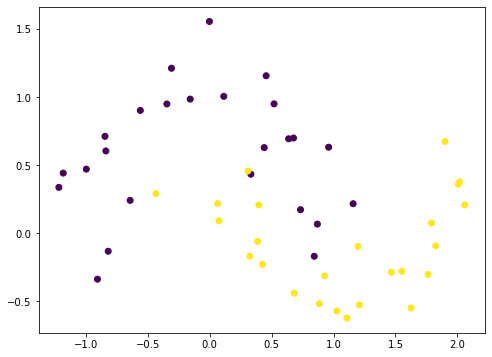

In [3]:
plt.figure(figsize = (8,6))
plt.scatter(X[:,0], X[:,1], c = y)

### Add Bias

In [4]:
def add_bias(arr):
    arr = np.hstack([arr,np.ones((arr.shape[0], 1))]) 
    return arr

In [5]:
X = add_bias(X)

### Define an activation function

In [6]:
def sigmoid(X):
    s = 1/(1+np.exp(-X))
    return s

def sigmoid_deriv(X):
   """derivative of sigmoid with respect to X"""
   return sigmoid(X) * (1-sigmoid(X))


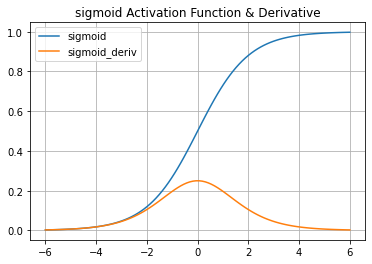

In [7]:
x_data = np.linspace(-6, 6, 100)
y_data = sigmoid(x_data)
dy_data = sigmoid_deriv(x_data)

plt.plot(x_data, y_data, x_data, dy_data)
plt.title('sigmoid Activation Function & Derivative')
plt.legend(['sigmoid', 'sigmoid_deriv'])
plt.grid()
plt.show()


In [8]:
def relu(x):
    return x * (x > 0)

def relu_deriv(x):
    return 1. * (x > 0)

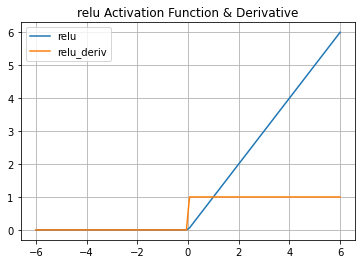

In [9]:
x_data = np.linspace(-6, 6, 100)
y_data = relu(x_data)
dy_data = relu_deriv(x_data)

plt.plot(x_data, y_data, x_data, dy_data)
plt.title('relu Activation Function & Derivative')
plt.legend(['relu', 'relu_deriv'])
plt.grid()
plt.show()

In [10]:
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, x * alpha)

def leaky_relu_deriv(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx


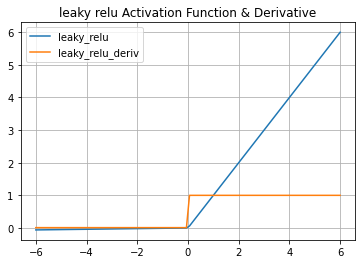

In [11]:
x_data = np.linspace(-6, 6, 100)
y_data = leaky_relu(x_data)
dy_data = leaky_relu_deriv(x_data)

plt.plot(x_data, y_data, x_data, dy_data)
plt.title('leaky relu Activation Function & Derivative')
plt.legend(['leaky_relu', 'leaky_relu_deriv'])
plt.grid()
plt.show()

In [12]:
def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def tanh_deriv(x):
  return 1 - tanh(x) * tanh(x)

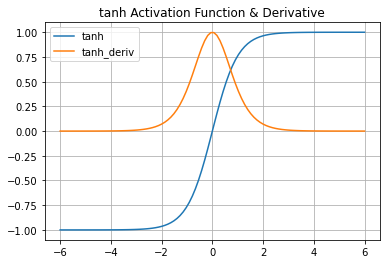

In [13]:
x_data = np.linspace(-6, 6, 100)
y_data = tanh(x_data)
dy_data = tanh_deriv(x_data)

plt.plot(x_data, y_data, x_data, dy_data)
plt.title('tanh Activation Function & Derivative')
plt.legend(['tanh', 'tanh_deriv'])
plt.grid()
plt.show()


### All functions in one plot:

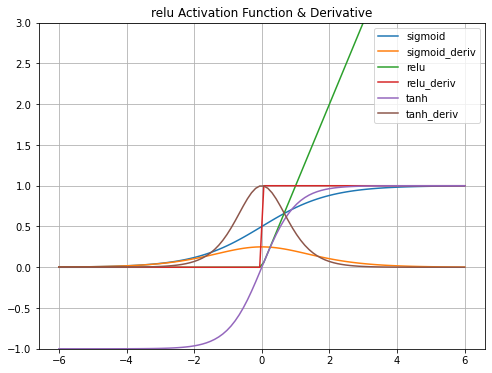

In [14]:
x_data = np.linspace(-6, 6, 100)
ys_data = sigmoid(x_data)
yds_data = sigmoid_deriv(x_data)
yr_data = relu(x_data)
ydr_data = relu_deriv(x_data)
yt_data = tanh(x_data) 
ydt_data = tanh_deriv(x_data)

plt.figure(figsize=(8, 6))
plt.plot(x_data, ys_data, x_data, yds_data, x_data, yr_data,
         x_data, ydr_data, x_data, yt_data,x_data, ydt_data)
plt.title('relu Activation Function & Derivative')
plt.legend(['sigmoid', 'sigmoid_deriv', 'relu', 'relu_deriv', 'tanh', 'tanh_deriv'])
plt.ylim(-1,3)
plt.grid()
plt.show()


##### Test sigmoid function

In [15]:
a = np.array([-10.0, -1.0, 0.0, 1.0, 10.0])
expected = np.array([0.0, 0.27, 0.5, 0.73, 1.0])
assert np.all(sigmoid(a).round(2) == expected)

### Weights are nitialized randomly

In [16]:
neurons = 4
weights_h = np.random.normal(size = (X.shape[1],neurons))
weights_o = np.random.normal(size = (neurons+1,1))
activationH1 = tanh
derivationH1 = tanh_deriv
activationO = sigmoid
derivationO = sigmoid_deriv


In [17]:
X.shape, weights_h.shape, weights_o.shape


((50, 3), (3, 4), (5, 1))

In [18]:
def feed_forward(X, weights):

    """
    1. Calculate the dot product of X
       and the weights of the first layer.

    2. Apply the sigmoid function on the result.

    3. Append an extra column of ones to the result (i.e. the bias).

    4. Calculate the dot product of the previous step
       with the weights of the second (i.e. outer) layer.

    5. Apply the sigmoid function on the result.

    6. Return all intermediate results (every output of an activation function).
    """

    # H_in
    weighted_sum = np.dot(X, weights[0])
    # H_out
    output_1 = activationH1(weighted_sum)
    #print(f'Shape of H_in = {weighted_sum.shape}')
    input_out = add_bias(output_1)
    # O_in
    weighted_sum = np.dot(input_out, weights[1])
    # O_out -> actual prediction
    output_2 = activationO(weighted_sum)
    
    return output_1, output_2

### Assertion Test

In [19]:
out1, out2 = feed_forward(X, [weights_h, weights_o])

In [20]:
assert out1.shape == (50, neurons)
assert out2.shape == (50, 1)

##### Plot result

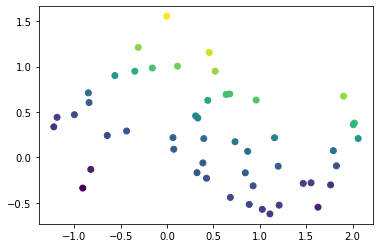

In [21]:
plt.scatter(X[:,0], X[:,1], c = out2)

--> the result is random, because weights have not been fitted.

### Calculating Accuracy
- flatten both ytrue and ypred (so that they're both (50,) arrays)
- round the ypred (either up to 1 or down to 0)
- then compare them to eachother to get a boolean array (True where the values are the same, False where they are not)
- sum the boolean array and divide by the length (i.e. take the mean)

In [22]:
def get_accuracy(ypred,ytrue):
    acc = sum(ytrue.flatten() == ypred.flatten().round().astype(np.int64))
    return acc/len(ytrue)

In [23]:
get_accuracy(out2, y)

0.5

## Backpropagation
Use gradient descent to fit the weights of the whole network.

#### Loss function

In [24]:
def log_loss(ytrue, ypred):
    loss = -(ytrue*np.log(ypred) + (1-ytrue)*np.log(1-ypred))
    return loss

#### Gradient (derivative) of the loss function

In [25]:
def loss_gradient(ytrue, ypred):
    new_ypred = []
    for n in ypred:
        if n == 0 or n ==1:
            n = n + 0.0000000001 
        new_ypred.append(n)
    new_ypred_array = np.array(new_ypred)
    loss = -ytrue/new_ypred_array + (1-ytrue)/(1-new_ypred_array)
    return loss


# def gradient_descent(gradient, start, learn_rate, n_iter=50, tolerance=1e-06):
#     vector = start
#     for _ in range(n_iter):
#         diff = -learn_rate * gradient(vector)
#         if np.all(np.abs(diff) <= tolerance):
#             break
#         vector += diff
#     return vector


In [26]:
def delta_cross_entropy(y_true, y_pred):
    """
    X is the output from fully connected layer (num_examples x num_classes)
    y is labels (num_examples x 1)
    	Note that y is not one-hot encoded vector. 
    	It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
    """
    y = y_true.argmax(axis=1)
    m = y.shape[0]
    grad = activationO(y_pred)
    grad[range(m), y] -= 1
    grad = grad/m
    return grad


### Backpropagation algorithm from scratch

In [27]:
def backprop(weights, output1, output2, ytrue,X_input, LR_O, LR_H):  
    #we separate learning rates for outer and inner weights.
    
    wH = weights[0]
    wO = weights[1]
    
    #STEP A:
    ytrue = ytrue.reshape(-1, 1) 
    error = loss_gradient(ytrue, output2)
    #print(f'Shape of Error: {error.shape}')
   
    #STEP B:
    sig_deriv = derivationO(output2)
    #derivative of the sigmoid function with respect to the hidden output * weights
    y_grad = sig_deriv * error
    #print(f'Shape of y_grad: {y_grad.shape}')
    
    #STEP C:
    hidden_out_with_bias = np.hstack([output1,np.ones((output1.shape[0],1))]) #don't forget the bias!
    delta_wo = np.dot( -y_grad.transpose(), hidden_out_with_bias ) * LR_O
    
    #and finally, old weights + delta weights -> new weights!
    wO_new = wO + delta_wo.transpose()
    #print(f'Shape of new outer weights: {wO_new.shape}')

    #STEP D:
    sig_deriv_2 = derivationH1(output1)
    H_grad = sig_deriv_2  * np.dot(y_grad , wO[:neurons].transpose()) 
    #exclude the bias (3rd column) of the outer weights, since it is not backpropagated!
    #print(f'Shape of H_grad: {H_grad.shape}')
    
    #STEP E:
    delta_wH = np.dot(-H_grad.transpose(), X_input ) * LR_H
    wH_new = wH + delta_wH.transpose() #old weights + delta weights -> new weights!
    #print(f'Shape of new hidden weights: {wH_new.shape}')
    
    return wH_new, wO_new

In [28]:
ACC_VEC = []
weights = [weights_h, weights_o]
for i in range(50):
    out1, out2 =  feed_forward(X, weights)
    ACC_VEC.append(get_accuracy(out2,y))
    new_weights = backprop(weights,out1,out2,y,X, LR_O=0.005, LR_H=0.0005)
    weights = new_weights

In [29]:
max(ACC_VEC)

0.76

Text(0, 0.5, 'accuracy')

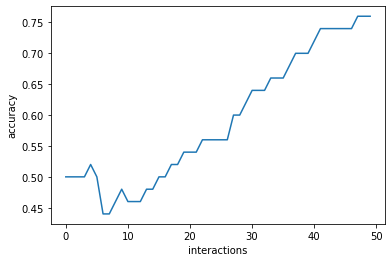

In [30]:
import matplotlib.pyplot as plt
plt.plot(ACC_VEC)
plt.xlabel('interactions')
plt.ylabel('accuracy')

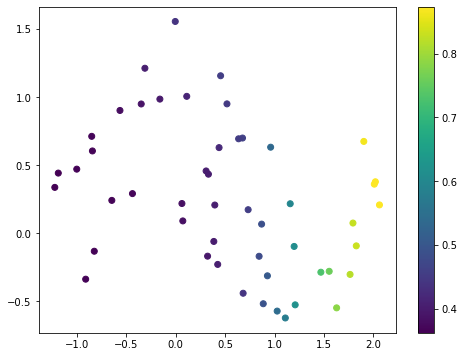

In [31]:
plt.figure(figsize = (8,6))
plt.scatter(X[:,0], X[:,1], c = out2)
plt.colorbar()